# Preliminary Analysis

### Basic loading and type definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('../Taller 1/datos.xlsx')

In [4]:
df['year'] = pd.to_datetime(df['year'], format = '%Y')

In [5]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [6]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [7]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [8]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            672 non-null    datetime64[ns]
 1   Produccion      672 non-null    float64       
 2   Reservas        672 non-null    float64       
 3   PIB             672 non-null    float64       
 4   Oil Prices      672 non-null    float64       
 5   pais            672 non-null    category      
 6   log_produccion  672 non-null    float64       
 7   log_reservas    672 non-null    float64       
 8   log_pib         672 non-null    float64       
 9   log_oil_prices  672 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(8)
memory usage: 49.3 KB


In [13]:
corr = df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']].corr()

In [14]:
corr

,log_pib,log_produccion,log_reservas,log_oil_prices
log_pib,1.000000,0.499878,0.045917,0.149381
log_produccion,0.499878,1.000000,0.714997,0.067388
log_reservas,0.045917,0.714997,1.000000,0.086968
log_oil_prices,0.149381,0.067388,0.086968,1.000000


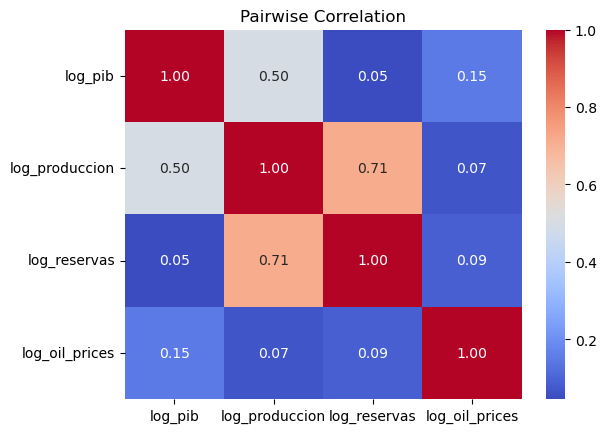

In [15]:
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f')
ax.set_title('Pairwise Correlation')
plt.show()

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [16]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)
    fig.show()


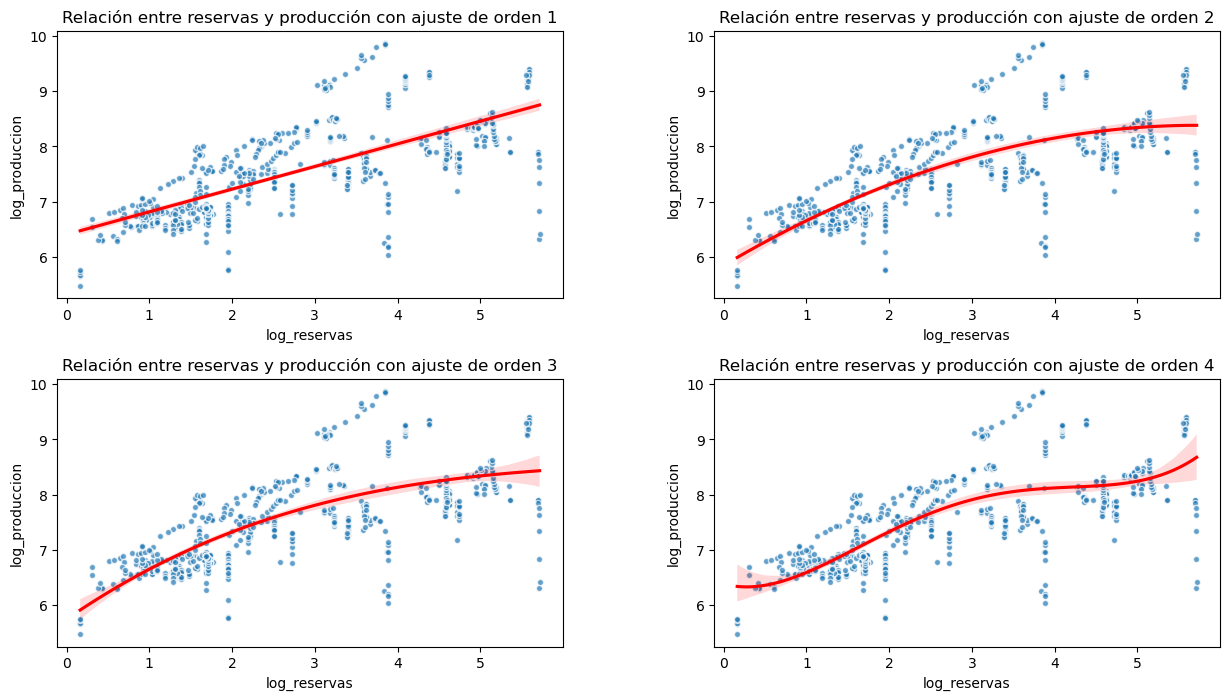

In [17]:
plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

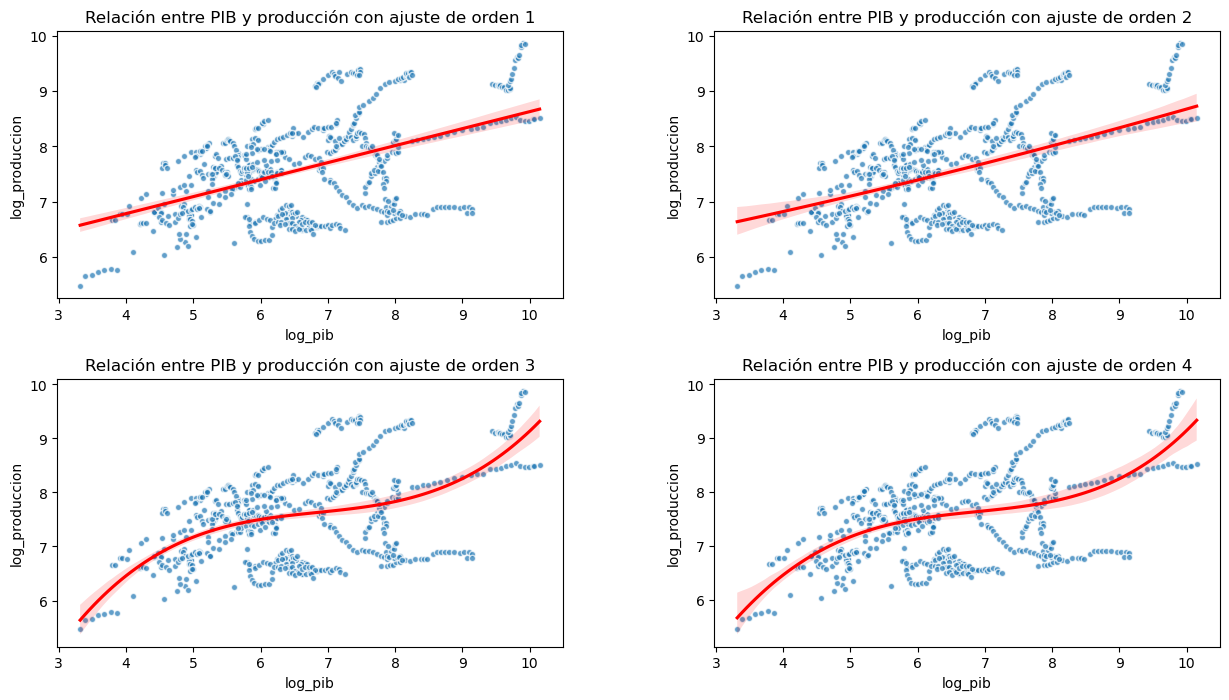

In [18]:
plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

### 5. Boxplot

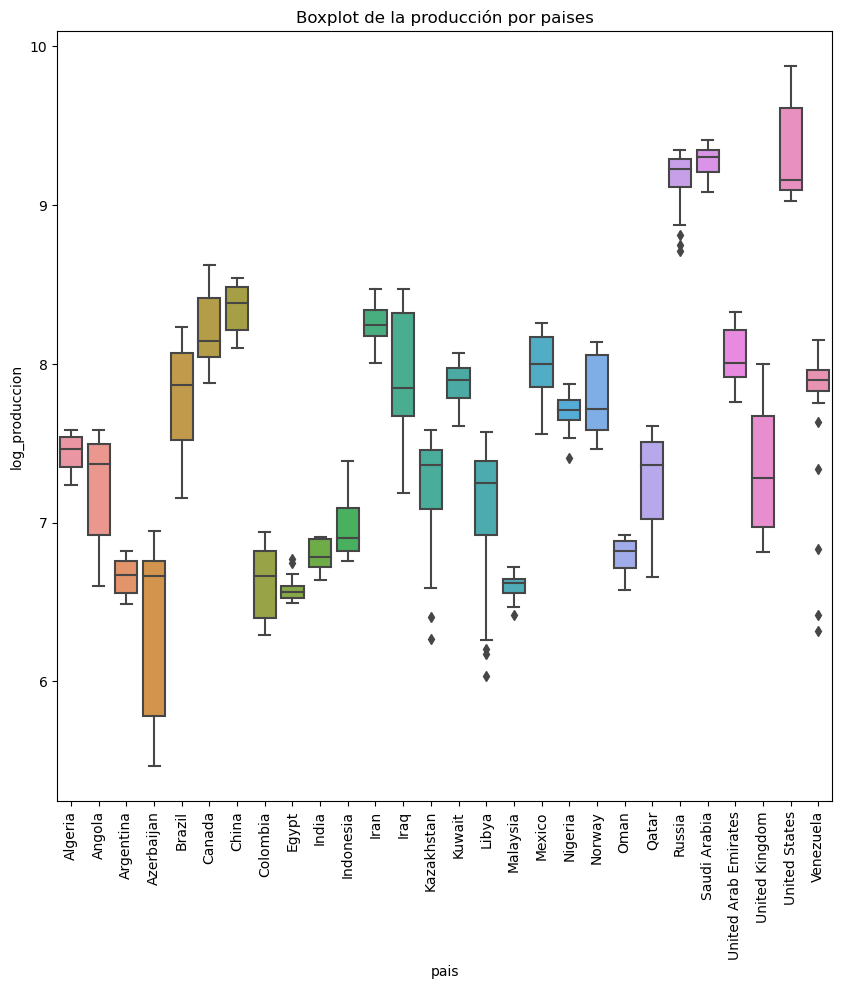

In [19]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.show()

### 6. Model Estimation

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [20]:
#df2 = df.set_index(['year', 'pais'], inplace = True)

In [21]:
df['lag_reserve'] = df['log_reservas'].shift(1)

In [22]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [23]:
df.columns

Index(['year', 'Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [24]:
import statsmodels.api as sm

In [25]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() #ESTIMAR EL MODELO
print(model1.summary()) #OUPUT DE LOS PRINCIPALES RESULTADOS

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     432.2
Date:                Thu, 16 Feb 2023   Prob (F-statistic):          1.96e-183
Time:                        07:52:25   Log-Likelihood:                -411.22
No. Observations:                 671   AIC:                             832.4
Df Residuals:                     666   BIC:                             855.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4731      0.150     29.

In [26]:
#df = pd.get_dummies(df, columns = ['pais'], drop_first = True)

In [27]:
df

,year,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve,lag_resq
0,1998-01-01,1402.410959,9.200,259.2931,13.126219,Algeria,7.245948,2.219203,5.557959,2.574612,NaN,NaN
1,1999-01-01,1388.601370,9.200,267.5905,18.108219,Algeria,7.236052,2.219203,5.589458,2.896366,2.219203,4.924864
2,2000-01-01,1433.025287,9.200,277.7589,28.845275,Algeria,7.267543,2.219203,5.626753,3.361946,2.219203,4.924864
3,2001-01-01,1513.892645,9.200,286.0917,24.713763,Algeria,7.322440,2.219203,5.656312,3.207360,2.219203,4.924864
4,2002-01-01,1617.653051,9.200,302.1128,25.115096,Algeria,7.388732,2.219203,5.710800,3.223469,2.219203,4.924864
...,...,...,...,...,...,...,...,...,...,...,...,...
667,2017-01-01,2066.046795,300.878,357.1842,54.886916,Venezuela,7.633392,5.706705,5.878252,4.005275,5.703626,32.531347
668,2018-01-01,1539.316118,302.250,287.0995,71.612593,Venezuela,7.339094,5.711254,5.659829,4.271271,5.706705,32.566480
669,2019-01-01,927.705271,302.809,191.3250,64.198474,Venezuela,6.832714,5.713102,5.253974,4.161979,5.711254,32.618428
670,2020-01-01,552.857158,302.809,122.1147,43.333843,Venezuela,6.315100,5.713102,4.804961,3.768934,5.713102,32.639537


In [28]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) #OUPUT DE LOS PRINCIPALES RESULTADOS

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     382.4
Date:                Thu, 16 Feb 2023   Prob (F-statistic):               0.00
Time:                        07:52:26   Log-Likelihood:                 156.88
No. Observations:                 671   AIC:                            -249.8
Df Residuals:                     639   BIC:                            -105.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 